# Assignment 1: PyTorch Basics

## Overview

In this assignment, you will:
1. Build a simple neural network from scratch to understand how neural networks work.
2. Train a neural network (using PyTorch) to classify images from the Mechanical Tools Classification dataset into one of 8 classes (hammer, wrench, pliers, etc.).

The provided code will guide you through key steps, but by the end of the assignment, you should:

1. Understand the training loop for a machine learning model.
2. Distinguish between training, validation, and test data.
3. Learn about overfitting and underfitting.
4. Explore how hyperparameters, like learning rate and batch size, impact training.
5. Compare a basic feedforward neural network (ANN) with a convolutional neural network (CNN).

This assignment is inspired by materials developed by Prof. Lisa Zhang.


## What to Submit

1. Submit the `.ipynb` and `.html` files containing your code, outputs, and answers from all parts. Please take extra effort to make your answers and submissions readable. Do not display unnecessary outputs, only the ones that are important for supporting your answers.

  You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.


2. Submit your model predictions on the secret test dataset for Parts B-5 and B-6 as `labels_part5.csv` and `labels_part6.csv`.

**Important**: Do not submit additional files generated by your code.

Please use Google Colab for this assignment. If you prefer Jupyter Notebook, ensure the file is uploaded to Colab for submission.


## Colab Link

Include a link to your colab file here and ensure the file can be accessed by the our teaching team.

Colab Link:

In [ ]:
# TO BE COMPLETED

# https://colab.research.google.com/github/Fulankeee/MIE1517-Project-1/blob/main/A1.ipynb

# PART A: Building a Neural Network from Scratch [8pt]

Before we get into using PyTorch to train our classifier we will go through the process of creating our neural network from scratch. We've seen in the tutorial how to build a 1-layer network, now we'll take it one step further to build a 2-layer network. This is an important exercise that everyone should attempt at least once to understand and truly appreciate the workings of neural networks.

## Helper Functions

To help guide the construction we will use the iris dataset that was introduced in the tutorial. Provided are some helper code to get us started:


In [1]:
# load "Iris_3class.csv" to Google Colab
from google.colab import files
uploaded = files.upload()

Saving Iris_3class.csv to Iris_3class.csv


In [2]:
import pandas as pd
import numpy as np

raw_data = pd.read_csv("Iris_3class.csv", header = None)
raw_data = raw_data.values
np.random.shuffle(raw_data)

In [3]:
import numpy as np
raw_data = raw_data.copy()

# split your data into training and validation
X_train = raw_data[0:100,:4]
y_train = raw_data[0:100,4:5].astype(int)
X_val = raw_data[100:,:4]
y_val = raw_data[100:,4:5].astype(int)

print(X_train.shape, y_train.shape)
print(X_train.dtype, y_train.dtype)
print(X_val.shape, y_val.shape)
print(X_val.dtype, y_val.dtype)

(100, 4) (100, 1)
float64 int64
(50, 4) (50, 1)
float64 int64


Recall that the neural network output consists of several nodes, one for each output class. Since the labels are provided as integers we will need to convert them into one-hot vectors to match the neural network output format.

In [4]:
#Convert array to one-hot encoding
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

In [5]:
y_train = to_one_hot(y_train)
print(X_train.shape, y_train.shape)
print(X_train.dtype, y_train.dtype)

y_val = to_one_hot(y_val)
print(X_val.shape, y_val.shape)
print(X_val.dtype, y_val.dtype)

(100, 4) (100, 3)
float64 float64
(50, 4) (50, 3)
float64 float64


In [6]:
#verify one-hot encoding
y_train[0:5,:]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

## Part A-1. Develop a 2-layer ANN [6pt MODEL]
At its core a 2-layer neural network is just a few lines of code. Most of the complexity comes from setting up the training of the network.

Using vectorized form, set up the neural network training to use a cross-entropy loss function and determine the gradients with resepect to the layer 1 and layer 2 weights.

In [7]:
# write code to create a 2-layer ANN in vectorized form

#define sigmoid
def sigmoid(x):
    return 1/(1+np.exp(-x))

#define softmax
def softmax(x):
  e = np.exp(x)
  return e/e.sum(axis=1, keepdims = True)


def ann(W, X_train, y_train):

  num_hidden = 5
  num_features = 4
  num_outputs = 3

  #Weights
  w0 = W[:20].reshape(num_features, num_hidden)
  w1 = W[20:].reshape(num_hidden, num_outputs)

  #Feed forward
  layer0 = X_train
  layer1 = sigmoid(np.dot(layer0, w0))
  layer2 = np.dot(layer1, w1)

  # softmax
  y_pred = softmax(layer2)

  # sample size
  m = X_train.shape[0]

  #Back propagation using gradient descent

  #cross-entropy loss
  error = -np.sum(y_train * np.log(y_pred))/m

  #initialize gradients to zero
  dw0, dw1 = np.zeros((num_features,num_hidden)), np.zeros((num_hidden,num_outputs))

  #calculate gradients
  dL_dlogit = y_pred - y_train
  dlogit_dv_hat = w1.T
  dv_hat_dv = layer1*(1-layer1)
  dv_dw0 = X_train
  dlogit_dw1 = layer1

  #determine gradients
  dw1 += dlogit_dw1.T.dot(dL_dlogit)
  dw0 += dv_dw0.T.dot((dL_dlogit.dot(dlogit_dv_hat)) * dv_hat_dv)

  #combine gradients into one vector
  dW = np.array(list(dw0.flatten()) + list(dw1.flatten()))

  return (error, dW, y_pred)


## Part A-2. Train your neural network [1pt RESULT]
How well does your network work on the iris dataset?

In [20]:
num_hidden = 5
num_features = 4
num_outputs = 3

#initialize weights
w0 = 2*np.random.random((num_features, num_hidden)) - 1
w1 = 2*np.random.random((num_hidden, num_outputs)) - 1

#combine weights into a single vector
W = np.array(list(w0.flatten()) + list(w1.flatten()))

#train network
n = 0.001
iterations = 100000
errors = []
for i in range(iterations):
  (error, dW, y_pred) = ann(W, X_train, y_train)
  W += -dW * n
  errors.append(error)

In [21]:
#examine predictions on training data
(error, dW, y_pred) = ann(W, X_train, y_train)
pred = np.round(y_pred, 1)
pred[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [22]:
#examine ground truth training data
train = np.round(y_train, 1)
train[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [23]:
# Display the traning error
print(f"The traning error of the model is {error}")

The traning error of the model is 0.0014011653514194571


## Part A-3. Validation [2pt MODEL]
Validate that the gradients were computed correctly for the 2-layer neural network you developed.

In [33]:
#write code to numerical verify the gradients you calculated

num_hidden = 5
num_features = 4
num_outputs = 3

#initialize weights
w0 = 2*np.random.random((num_features, num_hidden)) - 1
w1 = 2*np.random.random((num_hidden, num_outputs)) - 1

#combine weights
W = np.array(list(w0.flatten()) + list(w1.flatten()))

#compute gradients analytically
(error, dW, y_pred) = ann(W, X_train, y_train)

#compute gradients numerically
dW_num = np.zeros((len(W),1))

for ind in range(len(W)):
  #reset gradients
  We1 = np.array(list(w0.flatten()) + list(w1.flatten()))
  We2 = np.array(list(w0.flatten()) + list(w1.flatten()))

  #increment slightly
  We1[ind] += 0.0000001
  We2[ind] -= 0.0000001
  #compute errors
  (error_e1, dW_e1, y_pred1) = ann(We1, X_train, y_train)
  (error_e2, dW_e2, y_pred2) = ann(We2, X_train, y_train)

  #obtain numerical gradients
  grad_num = (error_e1 - error_e2) / (2 * 0.0000001)

  #display difference between numerical and analytic gradients
  print(abs(round(grad_num, 0)), abs(grad_num - dW[ind]), abs(dW[ind]))


0.0 3.488544434062998 3.52378225561257
0.0 0.2542978435586503 0.25686650883912826
0.0 13.764897897032483 13.90393727038051
0.0 8.732728685080689 8.820938065991387
0.0 23.2706671027178 23.50572434527692
0.0 1.750063815319088 1.7677412270757105
0.0 0.753032160320829 0.7606385458422704
0.0 0.5777238348392082 0.5835594290692718
0.0 6.114146285102959 6.1759053385298275
0.0 12.811049432609755 12.940453971916076
0.0 2.9330074620713527 2.962633801231058
0.0 1.1134484352858955 1.1246953886545221
0.0 25.287428548691192 25.542857120318384
0.0 2.206802904424822 2.229093842409159
0.0 15.960325765159006 16.121541177290105
0.0 1.2205399449001786 1.2328686318603954
0.0 0.5151171817856626 0.5203203852093385
0.0 11.202785103286882 11.315944548434441
0.0 0.2476410866477523 0.25014251127074383
0.0 6.037048062033223 6.0980283461888
0.0 15.345489354278204 15.500494297603414
0.0 19.20991424588162 19.403953783652483
0.0 3.8644248916034165 3.9034594860490692
0.0 15.400044620255644 15.555600626109795
0.0 16.509

# PART B: Training with PyTorch

In the second part of the assignment we will see how we can use PyTorch to train a neural network to identify different Mechanical Tools.


In [37]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

## Part B-0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [36]:
###############################################################################
# Data Loading

def get_data_loader(data_dir, batch_size, valid_split=0.2):
    """
    Load the Mechanical Tools Dataset, split into training, validation, and testing.

    Args:
        data_dir: The root directory of the dataset, with subdirectories for each class.
        batch_size: Number of samples per batch.
        valid_split: Fraction of the training data to be used for validation.

    Returns:
        train_loader: Iterable DataLoader for training data.
        val_loader: Iterable DataLoader for validation data.
        test_loader: Iterable DataLoader for testing data.
        classes: List of class names.
    """
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize to 128x128
        transforms.ToTensor(),         # Convert to Tensor
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])

    # Load the full dataset
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    classes = dataset.classes  # Get class names

    # Split the dataset
    total_size = len(dataset)
    test_size = int(0.1 * total_size)  # 10% for testing
    valid_size = int(valid_split * (total_size - test_size))  # Valid from remaining
    train_size = total_size - test_size - valid_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Normalize labels for multi-class classification.

    Args:
        labels: A 1D tensor of scalar class labels.
    Returns:
        The same labels (already suitable for multi-class classification).
    """
    return labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on a given dataset.

     Args:
         net: PyTorch neural network object.
         loader: PyTorch DataLoader for valuation data.
         criterion: The loss function.

     Returns:
         err: Average classification error rate over the validation set.
         loss: Average loss value over the validation set.
    """
    total_loss = 0.0
    total_err = 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = net(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Compute classification error
            _, predicted = torch.max(outputs, 1)
            total_err += (predicted != labels).sum().item()
            total_loss += loss.item()
            total_samples += len(labels)

    err = total_err / total_samples
    avg_loss = total_loss / len(loader)
    return err, avg_loss

###############################################################################
# Training Curve

def plot_training_curve(path):
    """ Plot training and validation error/loss curves.

    Args:
        path: Base path for the CSV files containing training logs.
    """
    import matplotlib.pyplot as plt

    train_err = np.loadtxt(f"{path}_train_err.csv")
    val_err = np.loadtxt(f"{path}_val_err.csv")
    train_loss = np.loadtxt(f"{path}_train_loss.csv")
    val_loss = np.loadtxt(f"{path}_val_loss.csv")

    plt.figure()
    plt.title("Train vs Validation Error")
    plt.plot(range(1, len(train_err) + 1), train_err, label="Train")
    plt.plot(range(1, len(val_err) + 1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()

    plt.figure()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1, len(train_loss) + 1), train_loss, label="Train")
    plt.plot(range(1, len(val_loss) + 1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


## Part B-1. Visualizing the Data

We will make use of the Mechanical Tools dataset, which consists of
color images of various mechanical tools such as hammers, wrenches,
screwdrivers, and more. These images are resized to 128x128 pixels.
You can find the dataset at https://www.kaggle.com/datasets/salmaneunus/mechanical-tools-dataset

Download the "mechanical_tools.zip" file from Quercus and upload it to your colab session storage.
Run the provided code to automatically unzip the dataset  and split the dataset into
training, validation, and testing sets.

In [42]:
_ = !unzip "/content/mechanical_tools.zip" -d "/content/mechanical_tools/"

In [28]:
# Load the Mechanical Tools Dataset
data_dir = "./mechanical_tools/mechanical_tools"  # Path to the dataset directory
batch_size = 1  # One image per batch for visualization

# Use the get_data_loader function to load the dataset
train_loader, val_loader, test_loader, classes = get_data_loader(
    data_dir=data_dir, batch_size=batch_size
)

### Part B-1(i) [0.5pt EXPLORATORY]

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

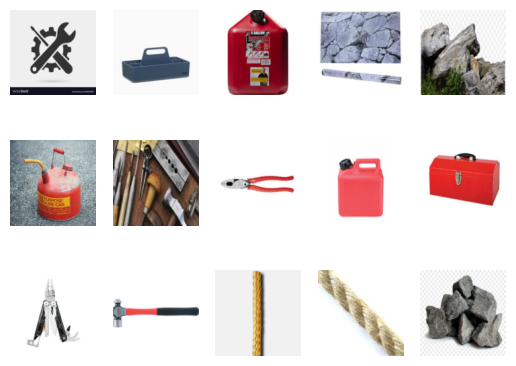

In [29]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part B-1(ii) [1pt EXPLORATORY]

How many training examples do we have for the combined classes?
What about validation examples?
What about test examples?

In [31]:
# TO BE COMPLETED
train_size = len(train_loader.dataset)
val_size = len(val_loader.dataset)
test_size = len(test_loader.dataset)
print(f"Number of training examples: {train_size}")
print(f"Number of validation examples: {val_size}")
print(f"Number of test examples: {test_size}")

Number of training examples: 1152
Number of validation examples: 288
Number of test examples: 160


In [32]:
'''
PROVIDE YOUR ANSWER BELOW

Number of training examples: 1152
Number of validation examples: 288
Number of test examples: 160
'''

'\nPROVIDE YOUR ANSWER BELOW\n\nNumber of training examples: 1152\nNumber of validation examples: 288\nNumber of test examples: 160\n'

## Part B-2. Training

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [33]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 29 * 29, 32)
        self.fc2 = nn.Linear(32, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [34]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 31 * 31, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 31 * 31)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [35]:
small_net = SmallNet()
large_net = LargeNet()

### Part B-2(i) [1pt EXPLORATORY]

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [36]:
for param in small_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([8, 4805])
torch.Size([8])


In [37]:
# TO BE COMPLETED
for param in large_net.parameters():
    print(param.shape)

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 8410])
torch.Size([32])
torch.Size([8, 32])
torch.Size([8])


In [38]:
size_small = 0
for param in small_net.parameters():
    size_small += np.prod(param.shape)
print(f"Total number of parameters in small_net: {size_small}")

size_large = 0
for param in large_net.parameters():
    size_large += np.prod(param.shape)
print(f"Total number of parameters in large_net: {size_large}")

Total number of parameters in small_net: 38588
Total number of parameters in large_net: 271056


In [39]:
'''
PROVIDE YOUR ANSWER BELOW

Total number of parameters in small_net: 38588
Total number of parameters in large_net: 271056
'''

'\nPROVIDE YOUR ANSWER BELOW\n\nTotal number of parameters in small_net: 38588\nTotal number of parameters in large_net: 271056\n'

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [40]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on an 8-class classification problem
    target_classes = ["Gasoline_Can", "Hammer", "Pebbels", "pliers",
                      "Rope", "Screw_Driver", "Toolbox", "Wrench"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible results
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            data_dir='/content/mechanical_tools/mechanical_tools',  # Ensure this is where your dataset is stored
            batch_size=batch_size)

    # Make sure the classes are as expected
    assert len(classes) == 8, "The dataset should have exactly 8 classes."
    ########################################################################
    # Define the Loss function and optimizer
    # Use CrossEntropyLoss for multi-class classification
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/accuracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # Loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)  # No need to normalize labels here for CrossEntropyLoss
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
            total_train_err += (predicted != labels).sum().item()  # Count errors
            total_train_loss += loss.item()
            total_epoch += len(labels)

        # Calculate error and loss for the training and validation set
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i + 1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)

        # Print stats for the current epoch
        print(f"Epoch {epoch + 1}: Train err: {train_err[epoch]:.4f}, Train loss: {train_loss[epoch]:.4f} | "
              f"Validation err: {val_err[epoch]:.4f}, Validation loss: {val_loss[epoch]:.4f}")

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} seconds")

    # Write the train/test loss/error into CSV files for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt(f"{model_path}_train_err.csv", train_err)
    np.savetxt(f"{model_path}_train_loss.csv", train_loss)
    np.savetxt(f"{model_path}_val_err.csv", val_err)
    np.savetxt(f"{model_path}_val_loss.csv", val_loss)


### Part B-2(ii) [0.5pt EXPLORATORY]

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

In [41]:
'''
PROVIDE YOUR ANSWER BELOW

batch_size=64,
learning_rate=0.01,
num_epochs=30

'''

'\nPROVIDE YOUR ANSWER BELOW\n\nbatch_size=64,\nlearning_rate=0.01,\nnum_epochs=30\n\n'

### Part B-2(iii) [0.5pt EXPLORATORY]
What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [42]:
'''
PROVIDE YOUR ANSWER BELOW

Model Checkpoints (5 files):
model_small_bs64_lr0.01_epoch0
model_small_bs64_lr0.01_epoch1
model_small_bs64_lr0.01_epoch2
model_small_bs64_lr0.01_epoch3
model_small_bs64_lr0.01_epoch4

Training and Validation Logs (4 files):
model_small_bs64_lr0.01_epoch4_train_err.csv
model_small_bs64_lr0.01_epoch4_train_loss.csv
model_small_bs64_lr0.01_epoch4_val_err.csv
model_small_bs64_lr0.01_epoch4_val_loss.csv

'''

'\nPROVIDE YOUR ANSWER BELOW\n\nModel Checkpoints (5 files):\nmodel_small_bs64_lr0.01_epoch0\nmodel_small_bs64_lr0.01_epoch1\nmodel_small_bs64_lr0.01_epoch2\nmodel_small_bs64_lr0.01_epoch3\nmodel_small_bs64_lr0.01_epoch4\n\nTraining and Validation Logs (4 files):\nmodel_small_bs64_lr0.01_epoch4_train_err.csv\nmodel_small_bs64_lr0.01_epoch4_train_loss.csv\nmodel_small_bs64_lr0.01_epoch4_val_err.csv\nmodel_small_bs64_lr0.01_epoch4_val_loss.csv\n\n'

### Part B-2(iv) [0.5pt EXPLORATORY]
Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in the parts that follow.
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [43]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the assignment locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [44]:
# TO BE COMPLETED
# Train small_net
print("Training small_net...")
start_time_small = time.time()
train_net(small_net)
end_time_small = time.time()
elapsed_time_small = end_time_small - start_time_small
print(f"Total time elapsed for small_net: {elapsed_time_small:.2f} seconds")

# Train large_net
print("Training large_net...")
start_time_large = time.time()
train_net(large_net)
end_time_large = time.time()
elapsed_time_large = end_time_large - start_time_large
print(f"Total time elapsed for large_net: {elapsed_time_large:.2f} seconds")

Training small_net...
Epoch 1: Train err: 0.7352, Train loss: 1.9406 | Validation err: 0.6562, Validation loss: 1.7891
Epoch 2: Train err: 0.5807, Train loss: 1.5436 | Validation err: 0.6389, Validation loss: 1.6796
Epoch 3: Train err: 0.5069, Train loss: 1.3855 | Validation err: 0.5903, Validation loss: 1.5882
Epoch 4: Train err: 0.4323, Train loss: 1.2199 | Validation err: 0.5660, Validation loss: 1.5306
Epoch 5: Train err: 0.3958, Train loss: 1.0925 | Validation err: 0.5799, Validation loss: 1.7008
Epoch 6: Train err: 0.3108, Train loss: 0.9323 | Validation err: 0.5799, Validation loss: 1.8168
Epoch 7: Train err: 0.2543, Train loss: 0.7412 | Validation err: 0.6111, Validation loss: 1.9001
Epoch 8: Train err: 0.1823, Train loss: 0.6124 | Validation err: 0.6007, Validation loss: 2.1291
Epoch 9: Train err: 0.1632, Train loss: 0.4959 | Validation err: 0.6111, Validation loss: 2.2767
Epoch 10: Train err: 0.1111, Train loss: 0.3784 | Validation err: 0.6076, Validation loss: 2.3524
Epoch 1

In [45]:
'''
PROVIDE YOUR ANSWER BELOW

Total time elapsed for small_net: 152.79 seconds
Total time elapsed for large_net: 231.80 seconds

The large network took longer to train because it has more parameters and more complex architecture.
'''

'\nPROVIDE YOUR ANSWER BELOW\n\nTotal time elapsed for small_net: 152.79 seconds\nTotal time elapsed for large_net: 231.80 seconds\n\nThe large network took longer to train because it has more parameters and more complex architecture.\n'

### Part B-2(v) [0.5pt EXPLORATORY]
Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

In [46]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)

Plotting training curves for small_net


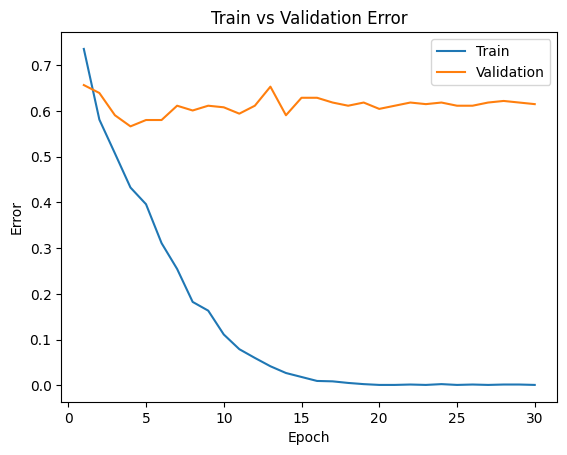

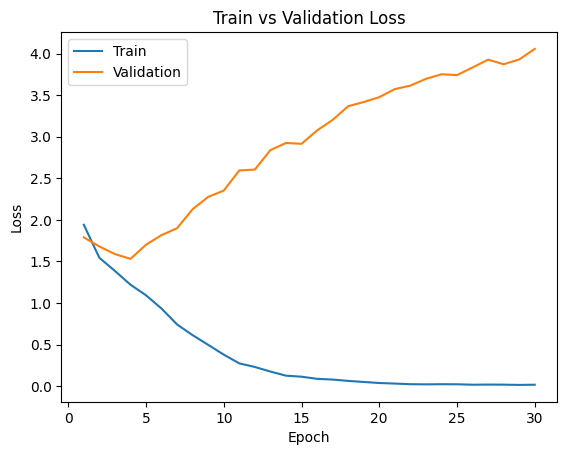

Plotting training curves for large_net


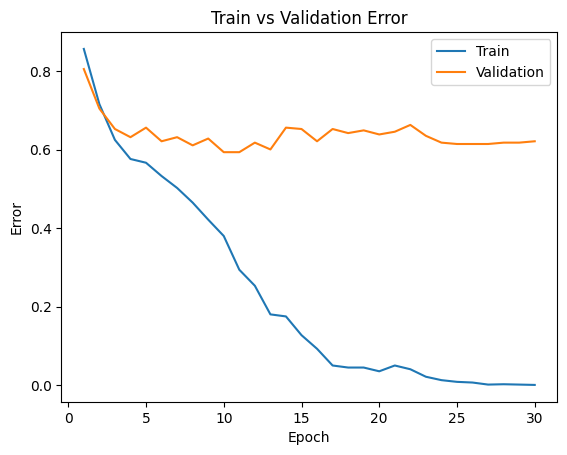

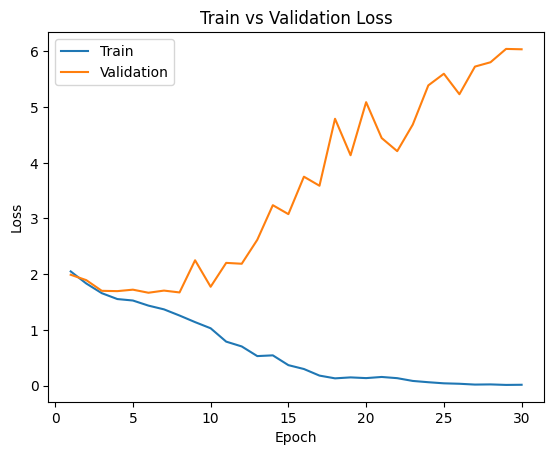

In [47]:
# TO BE COMPLETED
# Generate model names for small_net and large_net
small_net_name = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)  # Final epoch
large_net_name = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)  # Final epoch

print("Plotting training curves for small_net")
plot_training_curve(small_net_name)

print("Plotting training curves for large_net")
plot_training_curve(large_net_name)


### Part B-2(vi) [0.5pt EXPLORATORY]
Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [49]:
'''
PROVIDE YOUR ANSWER BELOW
Small net trains faster and achieves near-zero training error. But overfitting occurs early (10 epochs), with validation loss increasing and error plateauing.
Generalization: Performs worse than the large net on validation data.
Large net performs better, with lower validation error and delayed overfitting (20 epochs), but it trains slower due to higher parameter count, and still overfits eventuat the end.
By comparison, the small net is aster convergence but prone to earlier overfitting. the large net has better validation performance but slower convergence.

'''

'\nPROVIDE YOUR ANSWER BELOW\nSmall net trains faster and achieves near-zero training error. But overfitting occurs early (10 epochs), with validation loss increasing and error plateauing.\nGeneralization: Performs worse than the large net on validation data.\nLarge net performs better, with lower validation error and delayed overfitting (20 epochs), but it trains slower due to higher parameter count, and still overfits eventuat the end.\nBy comparison, the small net is aster convergence but prone to earlier overfitting. the large net has better validation performance but slower convergence.\n\n'

## Part B-3. Optimization Parameters

For this section, we will work with `large_net` only.

### Part B-3(i) [0.5pt EXPLORATORY]
Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [50]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

In [51]:
# TO BE COMPLETED

start_time = time.time()
train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=30)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total time elapsed: {elapsed_time:.2f} seconds")

Epoch 1: Train err: 0.8663, Train loss: 2.0815 | Validation err: 0.8854, Validation loss: 2.0806
Epoch 2: Train err: 0.8646, Train loss: 2.0734 | Validation err: 0.8889, Validation loss: 2.0713
Epoch 3: Train err: 0.8585, Train loss: 2.0622 | Validation err: 0.8854, Validation loss: 2.0555
Epoch 4: Train err: 0.8542, Train loss: 2.0413 | Validation err: 0.8507, Validation loss: 2.0273
Epoch 5: Train err: 0.8351, Train loss: 2.0078 | Validation err: 0.8090, Validation loss: 1.9891
Epoch 6: Train err: 0.7899, Train loss: 1.9661 | Validation err: 0.7882, Validation loss: 1.9590
Epoch 7: Train err: 0.7491, Train loss: 1.9278 | Validation err: 0.7535, Validation loss: 1.9330
Epoch 8: Train err: 0.7370, Train loss: 1.8897 | Validation err: 0.7188, Validation loss: 1.9137
Epoch 9: Train err: 0.6884, Train loss: 1.8414 | Validation err: 0.6944, Validation loss: 1.8703
Epoch 10: Train err: 0.6450, Train loss: 1.7746 | Validation err: 0.6910, Validation loss: 1.7967
Epoch 11: Train err: 0.6189, 

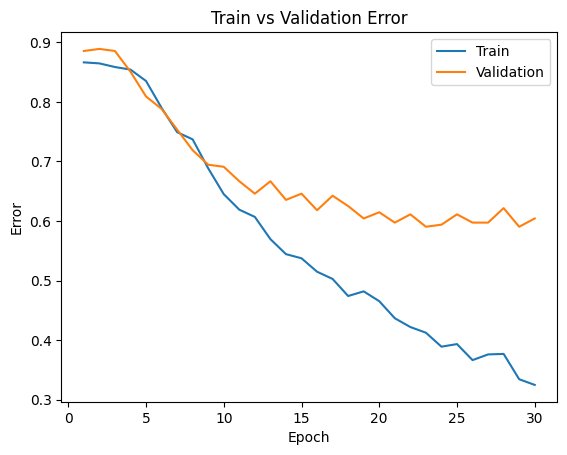

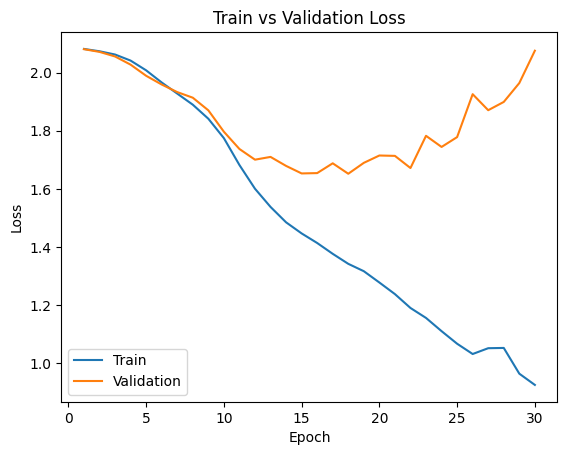

In [52]:
model_name = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_name)

In [53]:
'''
PROVIDE YOUR ANSWER BELOW
Total time elapsed for large_net (lr = 0.01): 231.80 seconds
Total time elapsed for large_net (lr = 0.001): 222.97 seconds

A lower learning rate takes smaller steps, requiring more iterations to converge. Therefore, I expected to see a longer training time than the default case.
However, training time with a smaller lr is shorter here due to noise in  gradients.

With a lower learning rate, training loss and error decrease more gradually over epochs compared to the default learning rate.
The model looks better, with a smaller gap between training and validation loss which means less overfitting.

'''

'\nPROVIDE YOUR ANSWER BELOW\nTotal time elapsed for large_net (lr = 0.01): 231.80 seconds\nTotal time elapsed for large_net (lr = 0.001): 222.97 seconds\n\nA lower learning rate takes smaller steps, requiring more iterations to converge. Therefore, I expected to see a longer training time than the default case.\nHowever, training time with a smaller lr is shorter here due to noise in  gradients.\n\nWith a lower learning rate, training loss and error decrease more gradually over epochs compared to the default learning rate.\nThe model looks better, with a smaller gap between training and validation loss which means less overfitting.\n\n'

### Part B-3(ii) [0.5pt EXPLORATORY]
Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Epoch 1: Train err: 0.8333, Train loss: 2.0070 | Validation err: 0.8333, Validation loss: 2.0260
Epoch 2: Train err: 0.7778, Train loss: 2.4241 | Validation err: 0.8299, Validation loss: 3.3601
Epoch 3: Train err: 0.8715, Train loss: 2.1709 | Validation err: 0.8715, Validation loss: 2.0927
Epoch 4: Train err: 0.8950, Train loss: 2.0905 | Validation err: 0.8924, Validation loss: 2.0863
Epoch 5: Train err: 0.8776, Train loss: 2.0821 | Validation err: 0.8576, Validation loss: 2.0790
Epoch 6: Train err: 0.8845, Train loss: 2.0828 | Validation err: 0.8681, Validation loss: 2.0826
Epoch 7: Train err: 0.8802, Train loss: 2.0829 | Validation err: 0.8576, Validation loss: 2.0787
Epoch 8: Train err: 0.8733, Train loss: 2.0843 | Validation err: 0.8785, Validation loss: 2.0861
Epoch 9: Train err: 0.8906, Train loss: 2.0846 | Validation err: 0.8715, Validation loss: 2.0777
Epoch 10: Train err: 0.8828, Train loss: 2.0848 | Validation err: 0.8681, Validation loss: 2.0827
Epoch 11: Train err: 0.8785, 

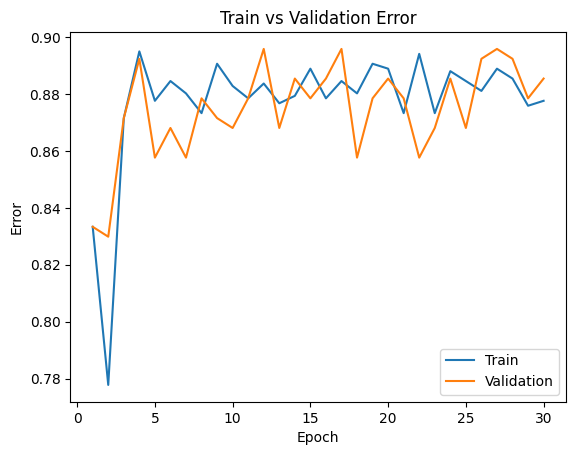

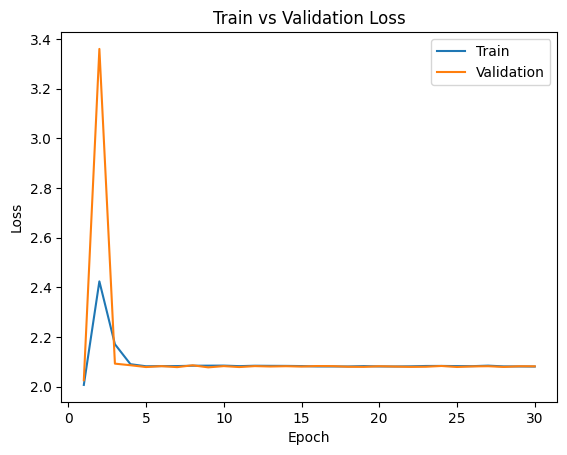

In [54]:
# TO BE COMPLETED
large_net = LargeNet()
start_time = time.time()
train_net(large_net, batch_size=64, learning_rate=0.1, num_epochs=30)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total time elapsed: {elapsed_time:.2f} seconds")

model_name = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_name)

In [55]:
'''
PROVIDE YOUR ANSWER BELOW
Total time elapsed for large_net (lr = 0.01): 231.80 seconds
Total time elapsed for large_net (lr = 0.1): 222.82 seconds

Increasing the learning rate doesn't affect the time per epoch, but it slightly takes shorter than our defualt learning rate due to larger steps in the direction of gradient.

Both training and validation error are consistently high, hovering around 0.85-0.90, indicating poor performance. Higher learning rates can cause oscillations or even divergence in the curves due to overshooting the optimal weights.
The model overfit sooner because larger updates will fit the training data aggressively.
'''

"\nPROVIDE YOUR ANSWER BELOW\nTotal time elapsed for large_net (lr = 0.01): 231.80 seconds\nTotal time elapsed for large_net (lr = 0.1): 222.82 seconds\n\nIncreasing the learning rate doesn't affect the time per epoch, but it slightly takes shorter than our defualt learning rate due to larger steps in the direction of gradient.\n\nBoth training and validation error are consistently high, hovering around 0.85-0.90, indicating poor performance. Higher learning rates can cause oscillations or even divergence in the curves due to overshooting the optimal weights.\nThe model overfit sooner because larger updates will fit the training data aggressively.\n"

### Part B-3(iii) [0.5pt EXPLORATORY]

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Epoch 1: Train err: 0.8594, Train loss: 2.0847 | Validation err: 0.8889, Validation loss: 2.0832
Epoch 2: Train err: 0.8655, Train loss: 2.0756 | Validation err: 0.8889, Validation loss: 2.0775
Epoch 3: Train err: 0.8533, Train loss: 2.0697 | Validation err: 0.8507, Validation loss: 2.0703
Epoch 4: Train err: 0.8307, Train loss: 2.0622 | Validation err: 0.8542, Validation loss: 2.0582
Epoch 5: Train err: 0.8273, Train loss: 2.0521 | Validation err: 0.8333, Validation loss: 2.0364
Epoch 6: Train err: 0.8194, Train loss: 2.0163 | Validation err: 0.8090, Validation loss: 2.0029
Epoch 7: Train err: 0.7969, Train loss: 1.9971 | Validation err: 0.7674, Validation loss: 1.9746
Epoch 8: Train err: 0.7682, Train loss: 1.9531 | Validation err: 0.7708, Validation loss: 1.9606
Epoch 9: Train err: 0.7613, Train loss: 1.9372 | Validation err: 0.7535, Validation loss: 1.9476
Epoch 10: Train err: 0.7214, Train loss: 1.8828 | Validation err: 0.7049, Validation loss: 1.9093
Epoch 11: Train err: 0.7040, 

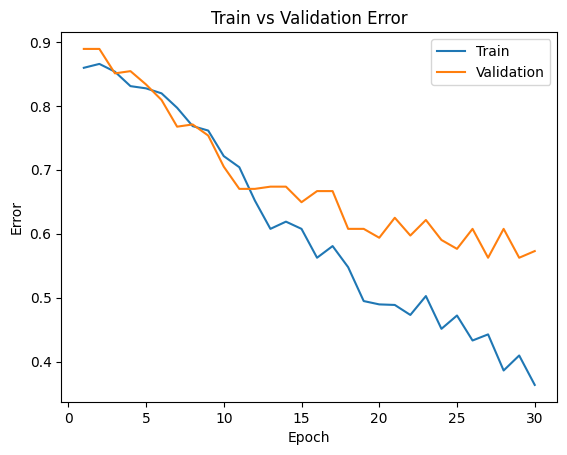

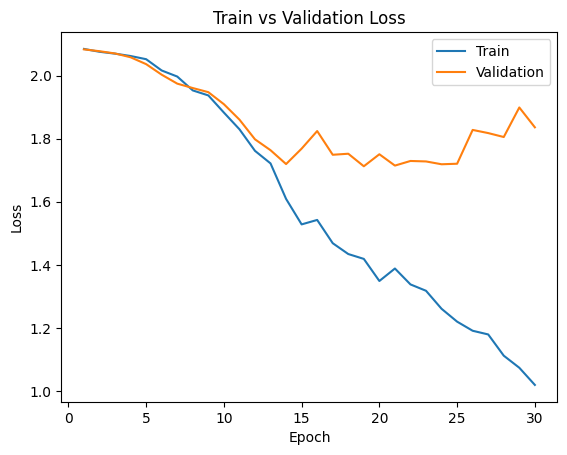

In [56]:
# TO BE COMPLETED
large_net = LargeNet()
start_time = time.time()
train_net(large_net, batch_size=512, learning_rate=0.01, num_epochs=30)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total time elapsed: {elapsed_time:.2f} seconds")

model_name = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_name)

In [57]:
'''
PROVIDE YOUR ANSWER BELOW
Total time elapsed for large_net (batch = 64): 231.80 seconds
Total time elapsed for large_net (batch = 512): 330.51 seconds

Time per Epoch is shorter with batch_size=512 due to fewer updates per epoch. The total training time increases because convergence slows with larger batch sizes
requires more epochs to achieve similar performance.

Larger batch sizes reduce noise in gradients, resulting in smoother training curves, but updates are less frequent. It is more stable in training.
'''

'\nPROVIDE YOUR ANSWER BELOW\nTotal time elapsed for large_net (batch = 64): 231.80 seconds\nTotal time elapsed for large_net (batch = 512): 330.51 seconds\n\nTime per Epoch is shorter with batch_size=512 due to fewer updates per epoch. The total training time increases because convergence slows with larger batch sizes\nrequires more epochs to achieve similar performance.\n\nLarger batch sizes reduce noise in gradients, resulting in smoother training curves, but updates are less frequent. It is more stable in training.\n'

### Part B-3(iv) [0.5pt EXPLORATORY]

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Epoch 1: Train err: 0.7977, Train loss: 1.9846 | Validation err: 0.7674, Validation loss: 1.8958
Epoch 2: Train err: 0.6589, Train loss: 1.7050 | Validation err: 0.7465, Validation loss: 1.8987
Epoch 3: Train err: 0.6250, Train loss: 1.6688 | Validation err: 0.8056, Validation loss: 1.9328
Epoch 4: Train err: 0.5972, Train loss: 1.5762 | Validation err: 0.7083, Validation loss: 1.8169
Epoch 5: Train err: 0.5347, Train loss: 1.4379 | Validation err: 0.6667, Validation loss: 1.8477
Epoch 6: Train err: 0.4774, Train loss: 1.3486 | Validation err: 0.7014, Validation loss: 1.8605
Epoch 7: Train err: 0.3785, Train loss: 1.0512 | Validation err: 0.6597, Validation loss: 1.9978
Epoch 8: Train err: 0.2405, Train loss: 0.7099 | Validation err: 0.5799, Validation loss: 2.4698
Epoch 9: Train err: 0.1780, Train loss: 0.5332 | Validation err: 0.6840, Validation loss: 3.5427
Epoch 10: Train err: 0.1667, Train loss: 0.5111 | Validation err: 0.6493, Validation loss: 3.7491
Epoch 11: Train err: 0.0938, 

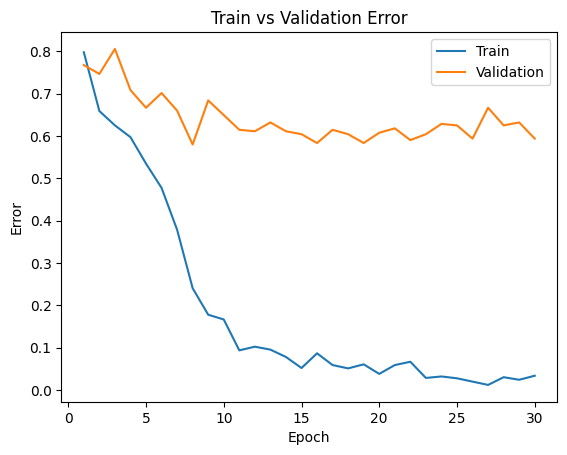

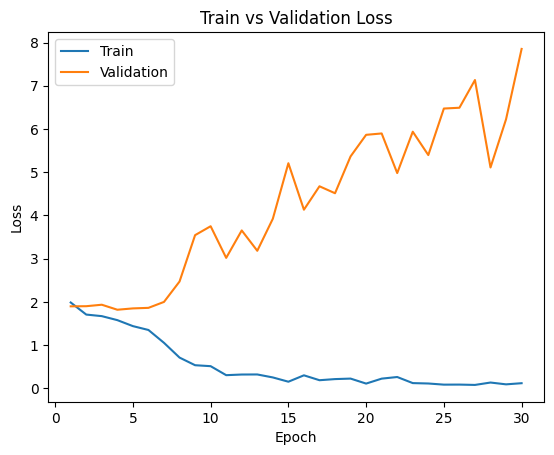

In [58]:
# TO BE COMPLETED
large_net = LargeNet()
start_time = time.time()
train_net(large_net, batch_size=16, learning_rate=0.01, num_epochs=30)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total time elapsed: {elapsed_time:.2f} seconds")

model_name = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_name)

In [59]:
'''
PROVIDE YOUR ANSWER BELOW
Total time elapsed for large_net (batch = 64): 231.80 seconds
Total time elapsed for large_net (batch = 16): 225.12 seconds

Time per Epoch is less with batch_size=16. The time spent decrease because it convergence faster with lower batch sizes which requires less epochs to achieve similar performance.

Smaller batch sizes increase noise in gradients, resulting in a less smooth training curves, but updates are more frequent. It is less stable in training compared with the default set.
'''

'\nPROVIDE YOUR ANSWER BELOW\nTotal time elapsed for large_net (batch = 64): 231.80 seconds\nTotal time elapsed for large_net (batch = 16): 225.12 seconds\n\nTime per Epoch is less with batch_size=16. The time spent decrease because it convergence faster with lower batch sizes which requires less epochs to achieve similar performance.\n\nSmaller batch sizes increase noise in gradients, resulting in a less smooth training curves, but updates are more frequent. It is less stable in training compared with the default set.\n'

## Part B-4. Hyperparameter Search

### Part B-4(i) [1pt EXPLORATORY]

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [60]:
'''
PROVIDE YOUR ANSWER BELOW

Use large_net for its higher capacity.
Set batch_size=128 for a balance between smooth updates and convergence speed.
Use learning_rate=0.001 for stable convergence.

Improved validation accuracy due to smoother convergence and reduced overfitting compared with the defualt values. I expected it to be faster and more stable training compared
to smaller batch sizes or higher learning rates.
'''

'\nPROVIDE YOUR ANSWER BELOW\n\nUse large_net for its higher capacity.\nSet batch_size=128 for a balance between smooth updates and convergence speed.\nUse learning_rate=0.001 for stable convergence.\n\nImproved validation accuracy due to smoother convergence and reduced overfitting compared with the defualt values. I expected it to be faster and more stable training compared\nto smaller batch sizes or higher learning rates.\n'

### Part B-4(ii) [0.5pt EXPLORATORY]

Train the model with the hyperparameters you chose in part(i), and include the training curve.

Epoch 1: Train err: 0.8628, Train loss: 2.0831 | Validation err: 0.8924, Validation loss: 2.0843
Epoch 2: Train err: 0.8672, Train loss: 2.0793 | Validation err: 0.8924, Validation loss: 2.0798
Epoch 3: Train err: 0.8646, Train loss: 2.0753 | Validation err: 0.8924, Validation loss: 2.0755
Epoch 4: Train err: 0.8611, Train loss: 2.0707 | Validation err: 0.8854, Validation loss: 2.0704
Epoch 5: Train err: 0.8611, Train loss: 2.0653 | Validation err: 0.8889, Validation loss: 2.0639
Epoch 6: Train err: 0.8542, Train loss: 2.0580 | Validation err: 0.8854, Validation loss: 2.0553
Epoch 7: Train err: 0.8464, Train loss: 2.0481 | Validation err: 0.8611, Validation loss: 2.0425
Epoch 8: Train err: 0.8481, Train loss: 2.0340 | Validation err: 0.8646, Validation loss: 2.0265
Epoch 9: Train err: 0.8394, Train loss: 2.0174 | Validation err: 0.8368, Validation loss: 2.0065
Epoch 10: Train err: 0.8281, Train loss: 1.9951 | Validation err: 0.8194, Validation loss: 1.9873
Epoch 11: Train err: 0.8038, 

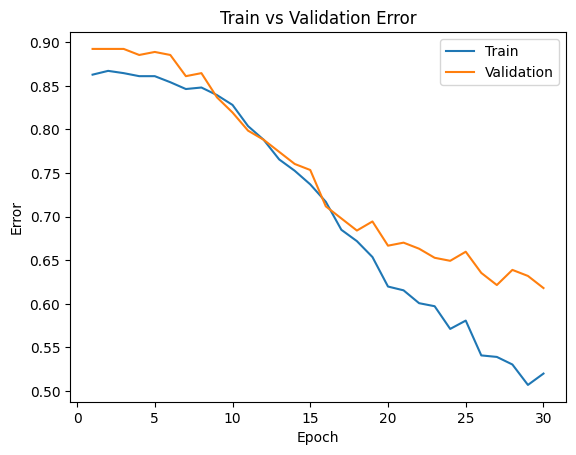

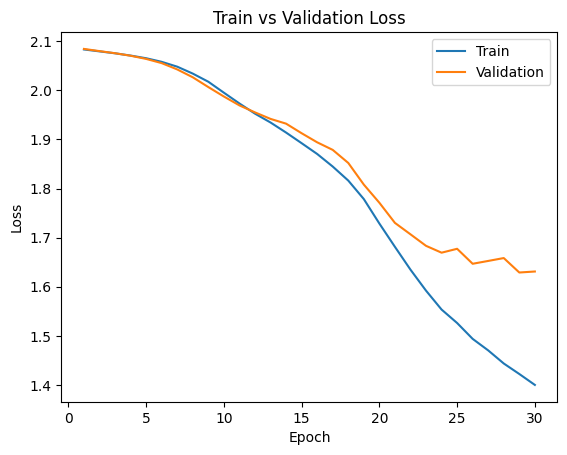

In [61]:
# TO BE COMPLETED
large_net = LargeNet()
start_time = time.time()
train_net(large_net, batch_size=128, learning_rate=0.001, num_epochs=30)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total time elapsed: {elapsed_time:.2f} seconds")

model_name = get_model_name("large", batch_size=128, learning_rate=0.001, epoch=29)
plot_training_curve(model_name)

### Part B-4(iii) [1pt EXPLORATORY]
Based on your result from Part(i), suggest another set of hyperparameter values to try.
Justify your choice.

In [62]:
'''
PROVIDE YOUR ANSWER BELOW

My hyperparameter values in part(i) has less overfitting, but low performance for training and validation error.
To imoprove it, I consider to improve the ability of reccognize more pattern each time by imcrease learning rate.
Same Batch Size = 128
By increasing the epoch to 50 and higher lr = 0.003 to prevent overshooting and learn more pattern.

'''

'\nPROVIDE YOUR ANSWER BELOW\n\nMy hyperparameter values in part(i) has less overfitting, but low performance for training and validation error.\nTo imoprove it, I consider to improve the ability of reccognize more pattern each time by imcrease learning rate.\nSame Batch Size = 128\nBy increasing the epoch to 50 and higher lr = 0.003 to prevent overshooting and learn more pattern.\n\n'

### Part B-4(iv) [0.5pt EXPLORATORY]

Train the model with the hyperparameters you chose in part(iii), and include the training curve.

In [63]:
# TO BE COMPLETED
# large_net = LargeNet()
# start_time = time.time()
# train_net(large_net, batch_size=128, learning_rate=0.008, num_epochs=30)
# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Total time elapsed: {elapsed_time:.2f} seconds")

# model_name = get_model_name("large", batch_size=128, learning_rate=0.0008, epoch=29)
# plot_training_curve(model_name)

Epoch 1: Train err: 0.8689, Train loss: 2.0817 | Validation err: 0.8854, Validation loss: 2.0799
Epoch 2: Train err: 0.8663, Train loss: 2.0732 | Validation err: 0.8854, Validation loss: 2.0694
Epoch 3: Train err: 0.8516, Train loss: 2.0599 | Validation err: 0.8750, Validation loss: 2.0493
Epoch 4: Train err: 0.8420, Train loss: 2.0325 | Validation err: 0.8264, Validation loss: 2.0097
Epoch 5: Train err: 0.8030, Train loss: 1.9884 | Validation err: 0.7847, Validation loss: 1.9665
Epoch 6: Train err: 0.7569, Train loss: 1.9425 | Validation err: 0.7743, Validation loss: 1.9376
Epoch 7: Train err: 0.7214, Train loss: 1.8905 | Validation err: 0.6944, Validation loss: 1.8919
Epoch 8: Train err: 0.6962, Train loss: 1.8366 | Validation err: 0.6875, Validation loss: 1.8535
Epoch 9: Train err: 0.6363, Train loss: 1.7436 | Validation err: 0.6944, Validation loss: 1.7623
Epoch 10: Train err: 0.6259, Train loss: 1.6509 | Validation err: 0.6528, Validation loss: 1.6808
Epoch 11: Train err: 0.6016, 

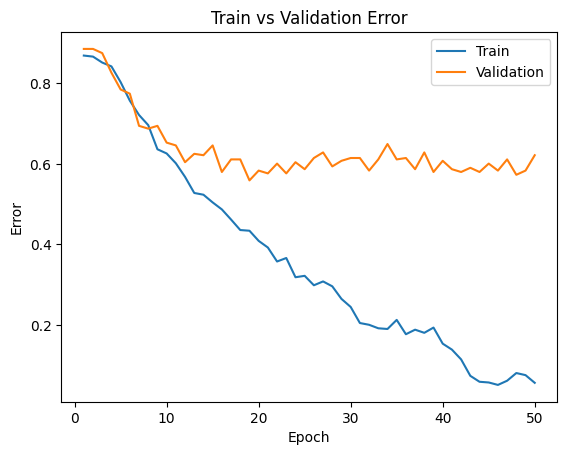

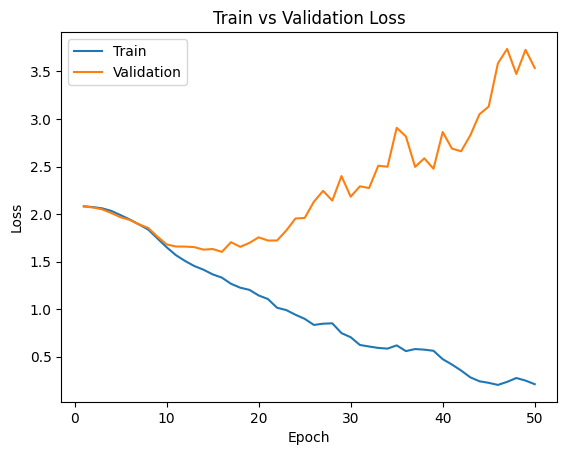

In [64]:
# TO BE COMPLETED
large_net = LargeNet()
start_time = time.time()
train_net(large_net, batch_size=128, learning_rate=0.003, num_epochs=50)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total time elapsed: {elapsed_time:.2f} seconds")

model_name = get_model_name("large", batch_size=128, learning_rate=0.003, epoch=49)
plot_training_curve(model_name)


## Part B-5. Evaluating the Best Model


### Part B-5(i) [2pt MODEL]

Summarize in a table the results achieved on training and validation on all your model selections. This includes choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**. Hint: you can import the Pandas module to create tables.


Then upon reviewing the results choose your **best** model and load the model checkpoint. You can modify the code below to load your chosen set of weights to the model object `net`.

In [65]:
import pandas as pd
data = {
    "Model":
     ["small_net", "large_net", "large_net", "large_net", "large_net", "large_net", "large_net", "large_net"],
    "Batch Size":
     [64, 64, 64, 64, 512, 16, 128, 128],
    "Learning Rate":
     [0.01, 0.01, 0.001, 0.1, 0.01, 0.01, 0.001, 0.003],
    "Epochs":
     [30, 30, 30, 30, 30, 30, 30, 50],
    "Train Error":
     [0.0009,0.5556,0.3247,0.8776,0.3637,0.0339,0.5000,0.0564],
    "Validation Error":
     [0.5556,0.5486,0.6042,0.8854,0.5729,0.5938,0.6076,0.6215]
}

results_df = pd.DataFrame(data)
results_df_sorted = results_df.sort_values("Validation Error", ascending=True)

results_df_sorted

,Model,Batch Size,Learning Rate,Epochs,Train Error,Validation Error
1,large_net,64,0.010,30,0.5556,0.5486
0,small_net,64,0.010,30,0.0009,0.5556
4,large_net,512,0.010,30,0.3637,0.5729
5,large_net,16,0.010,30,0.0339,0.5938
2,large_net,64,0.001,30,0.3247,0.6042
6,large_net,128,0.001,30,0.5000,0.6076
7,large_net,128,0.003,50,0.0564,0.6215
3,large_net,64,0.100,30,0.8776,0.8854


In [66]:
net = large_net
model_path = get_model_name(net.name, batch_size=512, learning_rate=0.01, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<ipython-input-66-c6a1743ea422>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


<All keys matched successfully>

### Part B-5(ii) [4pt DISCUSSION]

Justify your choice of model from Part (i).

In [67]:
'''
PROVIDE YOUR ANSWER BELOW

I choose the model with large_net, Batch Size = 512, Learning Rate = 0.010, Epochs = 30

The training error is not the lowest, it reflects a good level of learning without overfitting. The gap between training and validation errors is relatively small, indicating that the model generalizes well to unseen data.
A larger batch size reduces the noise in gradient updates, ensuring smoother convergence. It also allows faster epoch completion, making this configuration computationally efficient while maintaining good validation performance.
Lr = 0.01 is high enough to ensure faster convergence within 30 epochs without introducing instability or overshooting.
The valdiation error result is close and achieved with less overfitting and better stability due to the larger batch size.
'''

'\nPROVIDE YOUR ANSWER BELOW\n\nI choose the model with large_net, Batch Size = 512, Learning Rate = 0.010, Epochs = 30\n\nThe training error is not the lowest, it reflects a good level of learning without overfitting. The gap between training and validation errors is relatively small, indicating that the model generalizes well to unseen data.\nA larger batch size reduces the noise in gradient updates, ensuring smoother convergence. It also allows faster epoch completion, making this configuration computationally efficient while maintaining good validation performance.\nLr = 0.01 is high enough to ensure faster convergence within 30 epochs without introducing instability or overshooting.\nThe valdiation error result is close and achieved with less overfitting and better stability due to the larger batch size.\n'

### Part B-5(iii) [2pt RESULT]

Using the helper code in Part 0, any code from lecture notes, or any code that you write, compute and report the **test classification error** for your chosen model.

In [68]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
# train_loader, val_loader, test_loader, classes = get_data_loader(
#     data_dir=data_dir,
#     batch_size=64)

In [69]:
# TO BE COMPLETED
# Load the Mechanical Tools Dataset
data_dir = "./mechanical_tools/mechanical_tools"  # Path to the dataset directory
batch_size = 512

# Use the get_data_loader function to load the dataset
train_loader, val_loader, test_loader, classes = get_data_loader(
    data_dir=data_dir, batch_size=batch_size
)

chosen_model = large_net
model_name = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
model_path = f"{model_name}"


chosen_model.load_state_dict(torch.load(model_path))
criterion = nn.CrossEntropyLoss()
test_err, test_loss = evaluate(chosen_model, test_loader, criterion)


test_results = {
    "Test Error": test_err,
    "Test Loss": test_loss
}
test_results_df = pd.DataFrame(test_results, index=[0])
test_results_df

<ipython-input-69-cc29c6e7da9b>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chosen_model.load_state_dict(torch.load(model_path))


,Test Error,Test Loss
0,0.35625,1.104684


### Part B-5(iv) [3pt DISCUSSION]

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [70]:
'''
PROVIDE YOUR ANSWER BELOW

The test classification error is lower than the validation error, which is not as what I expect.

The test error is expected to be higher than the validation error because the model is indirectly tuned to perform better on the validation set during hyperparameter optimization.
The test set represents completely unseen data, making it a more realistic evaluation of the model's generalization ability.
The differences in data distributions or variability between the validation and test sets can also contribute to the higher test error.
Moreover, regularization techniques applied during training and validation might not be active during testing, leading to performance drop on the test set.



'''

"\nPROVIDE YOUR ANSWER BELOW\n\nThe test classification error is lower than the validation error, which is not as what I expect.\n\nThe test error is expected to be higher than the validation error because the model is indirectly tuned to perform better on the validation set during hyperparameter optimization.\nThe test set represents completely unseen data, making it a more realistic evaluation of the model's generalization ability.\nThe differences in data distributions or variability between the validation and test sets can also contribute to the higher test error.\nMoreover, regularization techniques applied during training and validation might not be active during testing, leading to performance drop on the test set.\n\n\n\n"

### Part B-5(v) [3pt DISCUSSION]
Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [71]:
'''
PROVIDE YOUR ANSWER BELOW

To ensure it serves as an unbiased evaluation of the model's performance on completely unseen data.
Repeated use of the test dataset during training or hyperparameter tuning can lead to data leakage.
To prevent overfitting to the test data. This ensures that the reported test performance is a reliable measure of how well the model would perform on new, real-world data.
Using the test set only at the end maintains the validity of our experimental setup and avoids misleadingly

'''

"\nPROVIDE YOUR ANSWER BELOW\n\nTo ensure it serves as an unbiased evaluation of the model's performance on completely unseen data.\nRepeated use of the test dataset during training or hyperparameter tuning can lead to data leakage.\nTo prevent overfitting to the test data. This ensures that the reported test performance is a reliable measure of how well the model would perform on new, real-world data.\nUsing the test set only at the end maintains the validity of our experimental setup and avoids misleadingly\n\n"

### Part B-5(vi) [3pt RESULT]
Preprocess the images from the secret test set provided below and classify these images into the 8 class labels from the mechanical tools dataset using your chosen model. Report the model predictions by your chosen model on this test dataset as a csv file called 'labels_part5.csv', containing the name of the images and their corresponsing predicted labels for all the images in the folder.

In [72]:
# !pip install wget

In [73]:
# import wget
# myfile = wget.download('https://github.com/Sabaae/Dataset/blob/main/secret_test.zip')

In [74]:
# Load the Dataset
_ = !unzip "/content/secret_test.zip" -d "/content/secret_test/"

In [75]:
import os
import torch
import pandas as pd
from torchvision import transforms
from PIL import Image

# Define image preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to match the model input size
    transforms.ToTensor(),         # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])


class_labels = ["Gasoline_Can", "Hammer", "Pebbles", "Pliers", "Rope", "Screw_Driver", "Toolbox", "Wrench"]
chosen_model = large_net
model_name = get_model_name("large", batch_size=512, learning_rate=0.010, epoch=29)
model_path = f"{model_name}"

# Load model checkpoint
chosen_model.load_state_dict(torch.load(model_path))
chosen_model.eval()

# Define the directory containing secret test images
secret_test_dir = "./secret_test/secret_test"

# Classify the secret test images
predictions = []
image_files = sorted(os.listdir(secret_test_dir))  # Ensure consistent ordering of images
for image_file in image_files:
    # Load and preprocess the image
    image_path = os.path.join(secret_test_dir, image_file)
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Predict the class
    with torch.no_grad():
        output = chosen_model(image)
        _, predicted = torch.max(output, 1)
        predicted_label = class_labels[predicted.item()]  # Map to class name

    # Store the result
    predictions.append({'Image': image_file, 'Label': predicted_label})

# Save predictions to a CSV file
output_csv = 'labels_part5.csv'
pd.DataFrame(predictions).to_csv(output_csv, index=False)


<ipython-input-75-ddb2a590bc62>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chosen_model.load_state_dict(torch.load(model_path))


## Part B-6. Fully-Connected Linear ANN vs CNN [4pt RESULT]

Test out a 3-layer linear fully-connected ANN architecture (see simpleANN below). You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.


Similar to what you did in the previous part, report the model predictions by your best ANN architecture on the secret test dataset as a csv file called 'labels_part6.csv', containing the names of the images and their corresopnding predicted labels for all the images in the folder.


How does the your best CNN model compare with an 2-layer linear ANN model (no convolutional layers) on classifying mechanical tools images?


In [38]:
class simpleANN(nn.Module):
    def __init__(self):
        super(simpleANN, self).__init__()
        self.name = "simple"
        self.fc1 = nn.Linear(128*128*3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 8)

    def forward(self, x):
        x = x.view(-1, 128*128*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch 1: Train err: 0.8194, Train loss: 2.0558 | Validation err: 0.7049, Validation loss: 1.9979
Epoch 2: Train err: 0.6875, Train loss: 1.9313 | Validation err: 0.6389, Validation loss: 1.8767
Epoch 3: Train err: 0.6311, Train loss: 1.7835 | Validation err: 0.6285, Validation loss: 1.7584
Epoch 4: Train err: 0.6484, Train loss: 1.6861 | Validation err: 0.6354, Validation loss: 1.7113
Epoch 5: Train err: 0.5694, Train loss: 1.5983 | Validation err: 0.6042, Validation loss: 1.6478
Epoch 6: Train err: 0.5712, Train loss: 1.5475 | Validation err: 0.5868, Validation loss: 1.6137
Epoch 7: Train err: 0.5373, Train loss: 1.5134 | Validation err: 0.6076, Validation loss: 1.6120
Epoch 8: Train err: 0.5139, Train loss: 1.4736 | Validation err: 0.5660, Validation loss: 1.5814
Epoch 9: Train err: 0.5260, Train loss: 1.4535 | Validation err: 0.6111, Validation loss: 1.5909
Epoch 10: Train err: 0.5234, Train loss: 1.4261 | Validation err: 0.5556, Validation loss: 1.5630
Epoch 11: Train err: 0.4722, 

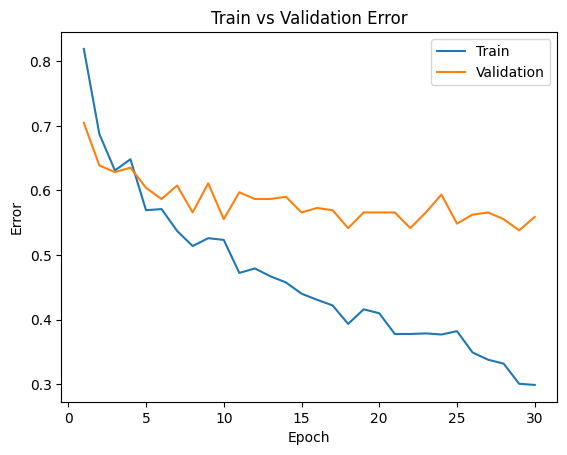

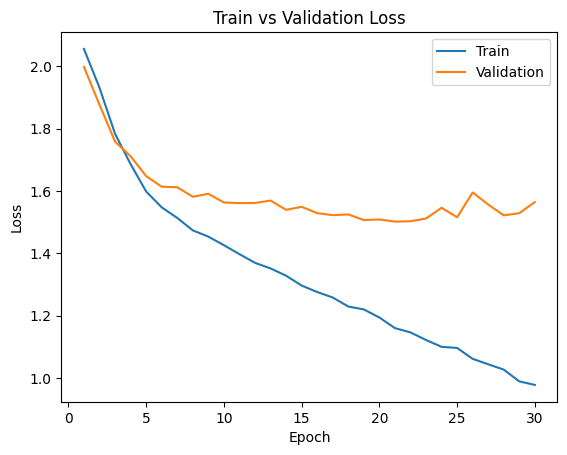

In [77]:
# TO BE COMPLETED
simpleANN = simpleANN()
train_net(simpleANN, batch_size=128, learning_rate=0.001, num_epochs=30)
model_name = get_model_name("simple", batch_size=128, learning_rate=0.001, epoch=29)
plot_training_curve(model_name)

Epoch 1: Train err: 0.8707, Train loss: 2.0599 | Validation err: 0.8542, Validation loss: 2.0479
Epoch 2: Train err: 0.8385, Train loss: 1.9945 | Validation err: 0.8021, Validation loss: 1.9934
Epoch 3: Train err: 0.7292, Train loss: 1.9142 | Validation err: 0.7292, Validation loss: 1.9224
Epoch 4: Train err: 0.6189, Train loss: 1.8326 | Validation err: 0.6701, Validation loss: 1.8537
Epoch 5: Train err: 0.6042, Train loss: 1.7521 | Validation err: 0.6667, Validation loss: 1.7984
Epoch 6: Train err: 0.5807, Train loss: 1.6803 | Validation err: 0.6458, Validation loss: 1.7552
Epoch 7: Train err: 0.5477, Train loss: 1.6314 | Validation err: 0.6354, Validation loss: 1.7198
Epoch 8: Train err: 0.5573, Train loss: 1.5972 | Validation err: 0.6285, Validation loss: 1.6896
Epoch 9: Train err: 0.5477, Train loss: 1.5749 | Validation err: 0.6181, Validation loss: 1.6684
Epoch 10: Train err: 0.5312, Train loss: 1.5317 | Validation err: 0.6389, Validation loss: 1.6624
Epoch 11: Train err: 0.5234, 

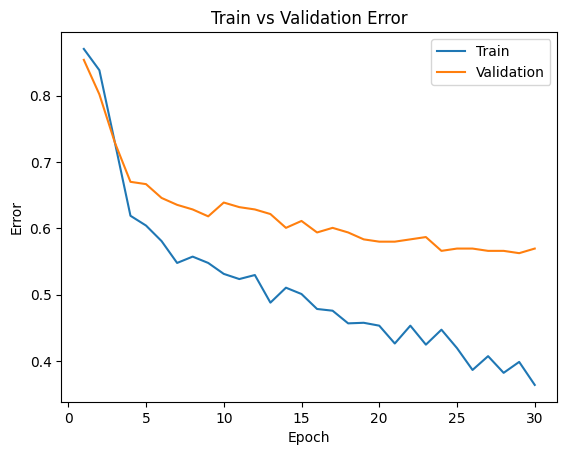

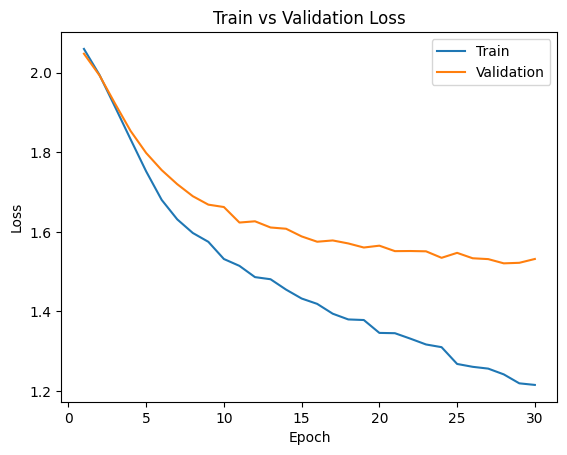

In [45]:
class simpleANN(nn.Module):
    def __init__(self):
        super(simpleANN, self).__init__()
        self.name = "simple"
        self.fc1 = nn.Linear(128*128*3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 8)

    def forward(self, x):
        x = x.view(-1, 128*128*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
simpleANN = simpleANN()
train_net(simpleANN, batch_size=256, learning_rate=0.001, num_epochs=30)
model_name = get_model_name("simple", batch_size=256, learning_rate=0.001, epoch=29)
plot_training_curve(model_name)

Epoch 1: Train err: 0.8359, Train loss: 2.0063 | Validation err: 0.7326, Validation loss: 1.9416
Epoch 2: Train err: 0.6510, Train loss: 1.7868 | Validation err: 0.7361, Validation loss: 1.8357
Epoch 3: Train err: 0.6476, Train loss: 1.6500 | Validation err: 0.6806, Validation loss: 1.6587
Epoch 4: Train err: 0.6241, Train loss: 1.5993 | Validation err: 0.6354, Validation loss: 1.5967
Epoch 5: Train err: 0.5686, Train loss: 1.4941 | Validation err: 0.6389, Validation loss: 1.5928
Epoch 6: Train err: 0.5095, Train loss: 1.4202 | Validation err: 0.6076, Validation loss: 1.5560
Epoch 7: Train err: 0.4731, Train loss: 1.3684 | Validation err: 0.5764, Validation loss: 1.5208
Epoch 8: Train err: 0.4470, Train loss: 1.3190 | Validation err: 0.6146, Validation loss: 1.5411
Epoch 9: Train err: 0.4609, Train loss: 1.3215 | Validation err: 0.6319, Validation loss: 1.5872
Epoch 10: Train err: 0.4635, Train loss: 1.2549 | Validation err: 0.6111, Validation loss: 1.6180
Epoch 11: Train err: 0.4271, 

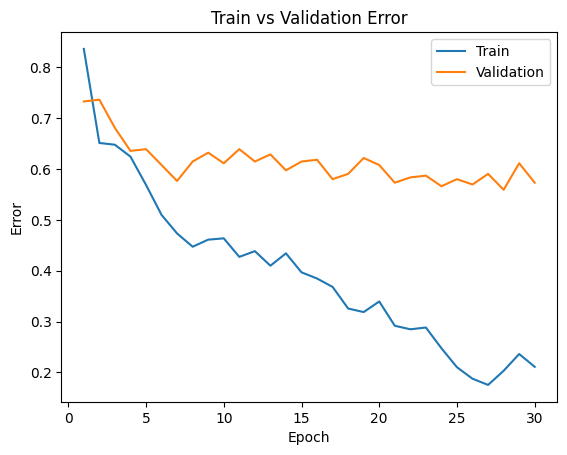

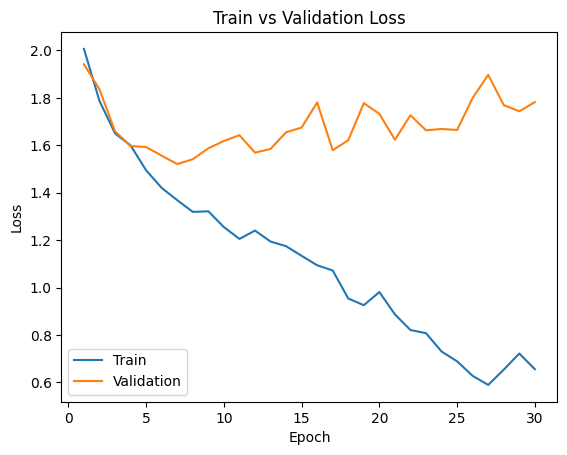

In [43]:
class simpleANN(nn.Module):
    def __init__(self):
        super(simpleANN, self).__init__()
        self.name = "simple"
        self.fc1 = nn.Linear(128*128*3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 8)

    def forward(self, x):
        x = x.view(-1, 128*128*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
simpleANN = simpleANN()
train_net(simpleANN, batch_size=256, learning_rate=0.005, num_epochs=30)
model_name = get_model_name("simple", batch_size=256, learning_rate=0.005, epoch=29)
plot_training_curve(model_name)

In [51]:
# test error
class simpleANN(nn.Module):
    def __init__(self):
        super(simpleANN, self).__init__()
        self.name = "simple"
        self.fc1 = nn.Linear(128*128*3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 8)

    def forward(self, x):
        x = x.view(-1, 128*128*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
data_dir = "./mechanical_tools/mechanical_tools"  # Path to the dataset directory
batch_size = 256

# Use the get_data_loader function to load the dataset
train_loader, val_loader, test_loader, classes = get_data_loader(
    data_dir=data_dir, batch_size=batch_size
)

class_labels = ["Gasoline_Can", "Hammer", "Pebbles", "Pliers", "Rope", "Screw_Driver", "Toolbox", "Wrench"]
chosen_model = simpleANN()
model_name = get_model_name("simple", batch_size = 256, learning_rate=0.001, epoch=29)
model_path = f"{model_name}"

chosen_model.load_state_dict(torch.load(model_path))
criterion = nn.CrossEntropyLoss()
test_err, test_loss = evaluate(chosen_model, test_loader, criterion)
test_results = {
    "Test Error": test_err,
    "Test Loss": test_loss
}
test_results_df = pd.DataFrame(test_results, index=[0])
test_results_df

<ipython-input-51-df0fca66591d>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chosen_model.load_state_dict(torch.load(model_path))


,Test Error,Test Loss
0,0.425,1.344144


The chosen hyperparameter is:  
Learning Rate = 0.001;  
Batch_size = 256;  
Epoch = 30;  
for the simpleANN model with test error of 0.425

In [92]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to match the model input size
    transforms.ToTensor(),         # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])


class_labels = ["Gasoline_Can", "Hammer", "Pebbles", "Pliers", "Rope", "Screw_Driver", "Toolbox", "Wrench"]
chosen_model = simpleANN()
model_name = get_model_name("simple", batch_size = 256, learning_rate=0.001, epoch=29)
model_path = f"{model_name}"

# Load model checkpoint
chosen_model.load_state_dict(torch.load(model_path))
chosen_model.eval()

# Define the directory containing secret test images
secret_test_dir = "./secret_test/secret_test"

# Classify the secret test images
predictions = []
image_files = sorted(os.listdir(secret_test_dir))  # Ensure consistent ordering of images
for image_file in image_files:
    # Load and preprocess the image
    image_path = os.path.join(secret_test_dir, image_file)
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Predict the class
    with torch.no_grad():
        output = chosen_model(image)
        _, predicted = torch.max(output, 1)
        predicted_label = class_labels[predicted.item()]  # Map to class name

    # Store the result
    predictions.append({'Image': image_file, 'Label': predicted_label})

# Save predictions to a CSV file
output_csv = 'labels_part6.csv'
pd.DataFrame(predictions).to_csv(output_csv, index=False)

<ipython-input-92-050af54f913d>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chosen_model.load_state_dict(torch.load(model_path))


# PART C (Optional) - Bonus Challenge!

This is an optional exercise for those that finish the assignment early and would like to perform a deeper exploration of the assignment.

In part A we constructed and trained a 2-layer neural network from scratch. In Part B we saw how PyTorch can be used to simplify the construction of neural networks by taking care of all the complexity related to gradient calculations, training on GPUs, and structuring your code.

For this bonus challenge we will propose additional task that will have you work towards completing the pipeline and deploying the models online, while exploring ways to improve these models along the way.

Tasks:

1. Modify your code to classify images that are not "Rope" or "Hammer" into the category "other".
2. Preprocess images from the internet to be able to classify any images into mechanical tools lables such as gasoline_can, hammer, etc. (i.e., resize, aspect ratio, etc.). Evaluate your best model's performance on images loaded from the internet.
3. Deploy your best model onto huggingface spaces (or other web hosting services) to classify images into the different mechanical tools classes.

Bonus marks will be provided based on the number of tasks completed and how well they are completed. Summarize below your results and anything intersting you learned from the steps that you completed. Bonus marks cannot be accumulated beyond a maximum assignment grade.

In [52]:
# TO BE COMPLETED
import requests
from io import BytesIO

# Download and preprocess an image from the internet
def preprocess_internet_image(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    preprocessed_image = transform(image).unsqueeze(1)
    return preprocessed_image

def classify_internet_image(url):
    image_tensor = preprocess_internet_image(url)
    chosen_model.eval()
    with torch.no_grad():
        output = chosen_model(image_tensor)
        _, predicted_index = torch.max(output, 1)
        class_name = original_classes[predicted_index.item()]
        return class_name if class_name in ["Hammer", "Rope"] else "Other"

In [53]:
# Preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class_labels = ["Hammer", "Rope", "Other"]
chosen_model = simpleANN
model_name = get_model_name("simple", batch_size = 256, learning_rate=0.001, epoch=29)
model_path = f"{model_name}"

In [61]:
# # To training the model, I'm still using the mechanical tools dataset, but I've included two helper functions for processing and classifing online images.
def train_net2(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on a 3-class classification problem
    target_classes = ["Hammer", "Rope", "Other"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible results
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    # Update `get_data_loader` to map 8-class labels into 3-class labels
    train_loader, val_loader, test_loader, original_classes = get_data_loader(
        data_dir='/content/mechanical_tools/mechanical_tools',  # Ensure this is where your dataset is stored
        batch_size=batch_size)

    # Ensure the original dataset has 8 classes
    assert len(original_classes) == 8, "The dataset should have exactly 8 classes."

    # Create a mapping from 8 classes to 3 classes
    def map_labels_to_three_classes(label):
        class_name = original_classes[label]
        if class_name == "Hammer":
            return 0  # Class index for "Hammer"
        elif class_name == "Rope":
            return 1  # Class index for "Rope"
        else:
            return 2  # Class index for "Other"

    ########################################################################
    # Define the Loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up numpy arrays to store training and validation metrics
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, (inputs, labels) in enumerate(train_loader, 0):
            # Map original 8-class labels to 3-class labels
            labels = torch.tensor([map_labels_to_three_classes(label.item()) for label in labels])

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate training metrics
            _, predicted = torch.max(outputs, 1)
            total_train_err += (predicted != labels).sum().item()
            total_train_loss += loss.item()
            total_epoch += len(labels)

        # Calculate training and validation metrics
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i + 1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)

        # Print stats for the epoch
        print(f"Epoch {epoch + 1}: Train err: {train_err[epoch]:.4f}, Train loss: {train_loss[epoch]:.4f} | "
              f"Validation err: {val_err[epoch]:.4f}, Validation loss: {val_loss[epoch]:.4f}")

        # Save model checkpoint
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} seconds")

    # Save metrics to CSV files
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt(f"{model_path}_train_err.csv", train_err)
    np.savetxt(f"{model_path}_train_loss.csv", train_loss)
    np.savetxt(f"{model_path}_val_err.csv", val_err)
    np.savetxt(f"{model_path}_val_loss.csv", val_loss)

Epoch 1: Train err: 0.4861, Train loss: 1.5479 | Validation err: 0.8993, Validation loss: 4.3790
Epoch 2: Train err: 0.3811, Train loss: 1.1102 | Validation err: 0.8854, Validation loss: 6.1419
Epoch 3: Train err: 0.3342, Train loss: 1.0122 | Validation err: 0.8750, Validation loss: 6.5441
Epoch 4: Train err: 0.2925, Train loss: 0.8102 | Validation err: 0.8576, Validation loss: 6.5689
Epoch 5: Train err: 0.2552, Train loss: 0.7368 | Validation err: 0.8542, Validation loss: 6.5417
Epoch 6: Train err: 0.2578, Train loss: 0.7031 | Validation err: 0.8507, Validation loss: 6.9337
Epoch 7: Train err: 0.2561, Train loss: 0.6935 | Validation err: 0.8507, Validation loss: 7.2271
Epoch 8: Train err: 0.2483, Train loss: 0.6911 | Validation err: 0.8507, Validation loss: 7.2901
Epoch 9: Train err: 0.2509, Train loss: 0.6679 | Validation err: 0.8611, Validation loss: 7.3033
Epoch 10: Train err: 0.2500, Train loss: 0.6466 | Validation err: 0.8507, Validation loss: 7.8633
Epoch 11: Train err: 0.2439, 

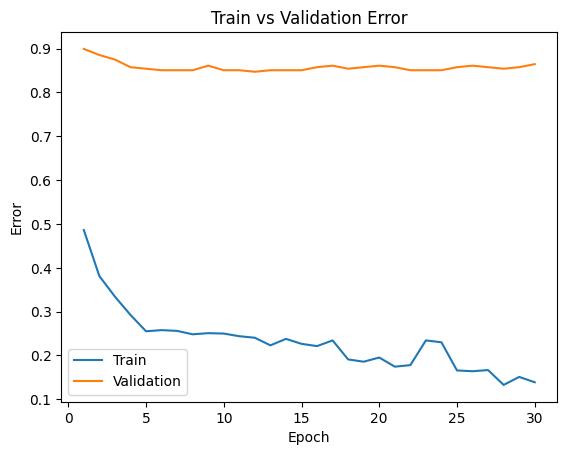

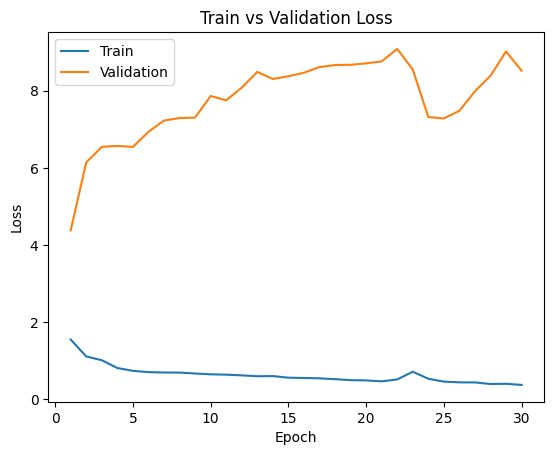

In [62]:
# Try the simple_net
class simpleANN(nn.Module):
    def __init__(self):
        super(simpleANN, self).__init__()
        self.name = "simple"
        self.fc1 = nn.Linear(128*128*3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 8)

    def forward(self, x):
        x = x.view(-1, 128*128*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

simpleANN = simpleANN()
train_net2(simpleANN, batch_size=256, learning_rate=0.005, num_epochs=30)
model_name = get_model_name("simple", batch_size=256, learning_rate=0.005, epoch=29)
plot_training_curve(model_name)

Epoch 1: Train err: 0.7977, Train loss: 1.9846 | Validation err: 0.7674, Validation loss: 1.8958
Epoch 2: Train err: 0.6589, Train loss: 1.7050 | Validation err: 0.7465, Validation loss: 1.8987
Epoch 3: Train err: 0.6250, Train loss: 1.6688 | Validation err: 0.8056, Validation loss: 1.9328
Epoch 4: Train err: 0.5972, Train loss: 1.5762 | Validation err: 0.7083, Validation loss: 1.8169
Epoch 5: Train err: 0.5347, Train loss: 1.4379 | Validation err: 0.6667, Validation loss: 1.8477
Epoch 6: Train err: 0.4774, Train loss: 1.3486 | Validation err: 0.7014, Validation loss: 1.8605
Epoch 7: Train err: 0.3785, Train loss: 1.0512 | Validation err: 0.6597, Validation loss: 1.9978
Epoch 8: Train err: 0.2405, Train loss: 0.7099 | Validation err: 0.5799, Validation loss: 2.4698
Epoch 9: Train err: 0.1780, Train loss: 0.5332 | Validation err: 0.6840, Validation loss: 3.5427
Epoch 10: Train err: 0.1667, Train loss: 0.5111 | Validation err: 0.6493, Validation loss: 3.7491
Epoch 11: Train err: 0.0938, 

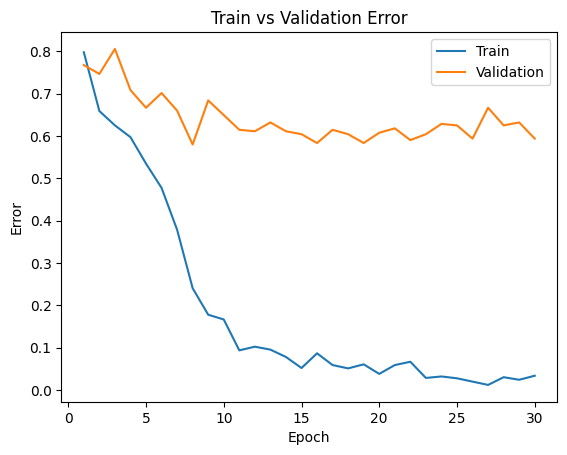

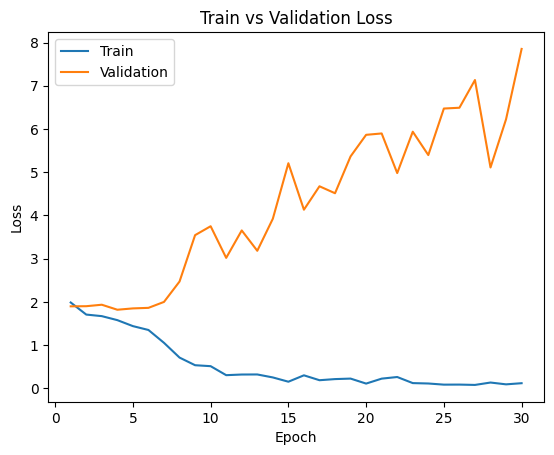

In [63]:
# Try the large net
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 29 * 29, 32)
        self.fc2 = nn.Linear(32, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

large_net = LargeNet()
train_net(large_net, batch_size=16, learning_rate=0.01, num_epochs=30)
model_name = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_name)

Epoch 1: Train err: 0.8681, Train loss: 2.0656 | Validation err: 0.7986, Validation loss: 2.0103
Epoch 2: Train err: 0.7274, Train loss: 1.9155 | Validation err: 0.7014, Validation loss: 1.8707
Epoch 3: Train err: 0.6276, Train loss: 1.6829 | Validation err: 0.6493, Validation loss: 1.8531
Epoch 4: Train err: 0.5564, Train loss: 1.5341 | Validation err: 0.6076, Validation loss: 1.6532
Epoch 5: Train err: 0.5078, Train loss: 1.4110 | Validation err: 0.6007, Validation loss: 1.6830
Epoch 6: Train err: 0.5052, Train loss: 1.3559 | Validation err: 0.5451, Validation loss: 1.5725
Epoch 7: Train err: 0.4523, Train loss: 1.2439 | Validation err: 0.5625, Validation loss: 1.5777
Epoch 8: Train err: 0.3837, Train loss: 1.1041 | Validation err: 0.5486, Validation loss: 1.7176
Epoch 9: Train err: 0.3559, Train loss: 1.0605 | Validation err: 0.5486, Validation loss: 1.8212
Epoch 10: Train err: 0.3941, Train loss: 1.0254 | Validation err: 0.5590, Validation loss: 1.8060
Epoch 11: Train err: 0.2839, 

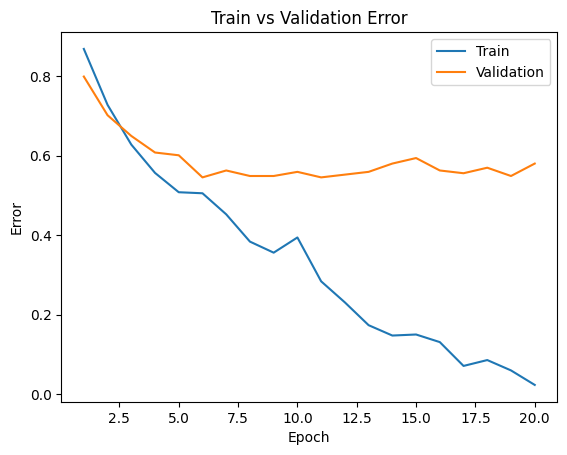

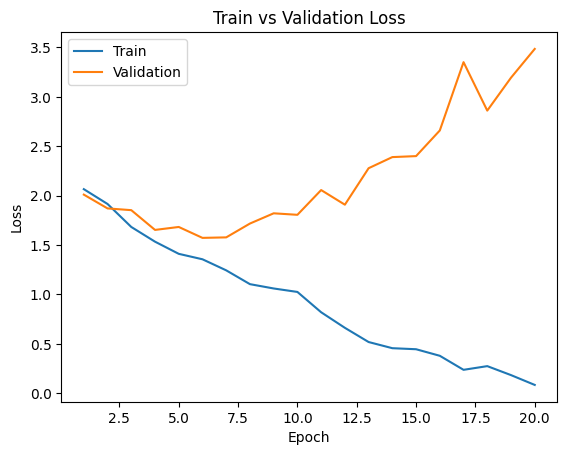

In [65]:
# Try the large net
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 29 * 29, 32)
        self.fc2 = nn.Linear(32, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.01, num_epochs=20)
model_name = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=19)
plot_training_curve(model_name)

### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [ ]:
%%shell
jupyter nbconvert --to html A1.ipynb

(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus

# Assignment Grading Rubric
The grading of the assignment will be based on the following categories:

(1) **10 Pt - EXPLORATORY QUESTIONS** These are basic questions that in most cases can be answered without requiring a fully working and trained neural network model. For example, data loading, processing and visualization, summary statistics, data exploration, model and training setup, etc.

(2) **10 Pt - MODEL** Student has successfully implemented all the required neural network models and has demonstrated successful training of the model without any errors.

(3) **10 Pt - RESULT** Students are evaluated based on the results achieved in comparison to the expected results of the assignment.

(4) **10 Pt - DISCUSSION QUESTIONS** Student demonstrated understanding beyond the basic exploratory questions, can answer some of the more challenging questions, and provide arguments for their model selection decisions.

(5) **10 Pt - COMMUNICATION** Student has provided a quality submission that is easy to read without too many unnecessary output statements that distract the reading of the document. The code has been well commented and all the answers are communicated clearly and concisely.

(6) **5 Pt - BONUS** Student has completed the assignment and has taken on the challenging bonus tasks listed in PART C. The student has demonstrated a good understanding of all aspects of the assignment and has exceeded expectations for the assignment.



**TOTAL GRADE = _____ of 50 Pts**